# Early Prediction with Background Features Only

## Objective

Train a predictive model using **only background features available at admission** - before students take any classes. This enables extremely early intervention during orientation or the first week, rather than waiting until after first semester grades.

**Research Question:** How much of student success can be predicted from pre-enrollment factors alone?

**Features INCLUDED (Background Only):**
- Demographics: Age, Gender, Marital status, Nationality
- Socioeconomic: Parent education/occupation
- Financial: Debtor status, Tuition payment, Scholarship
- Academic background: Previous qualification, Admission grade
- Course/Program

**Features EXCLUDED (Academic Performance):**
- All semester grades (1st/2nd)
- Enrolled/approved units
- Engineered features (success_rate, grade_trend, early_warning, has_zero_grade)

**Expected Results:**
- Hypothesis: 60-65% accuracy
- Comparison: Full model achieves 76.72%
- Baseline: Dummy classifier achieves 49.93%

---

## Section 1: Imports and Setup

In [40]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# XGBoost
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("XGBoost not available")

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"XGBoost available: {xgboost_available}")

Libraries imported successfully!
XGBoost available: True


## Section 2: Load Data

In [41]:
# Load data
df = pd.read_csv('../data/data.csv', delimiter=';')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nTarget distribution:")
print(df['Target'].value_counts(normalize=True).sort_index())

# Create working copy
df_background = df.copy()

Dataset loaded: 4424 rows, 37 columns

Target distribution:
Target
Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: proportion, dtype: float64


## Section 3: Category Grouping

Apply same grouping functions as in baseline model for consistency.

In [42]:
def categorize_parent_education(code):
    """
    Categorize education based on codebook values.
    Returns ordered categories: 0 (lowest) to 5 (highest)
    """
    if code in [35, 36]:  # Cannot read/write or can read without 4th year
        return 0  # 'No formal education'
    elif code in [29, 30, 37, 38]:  # Basic education (4th-9th year)
        return 1  # 'Basic Education'
    elif code in [9, 10, 11, 12, 14, 18, 19, 22, 26, 27]:  # Incomplete secondary
        return 2  # 'Secondary (Incomplete)'
    elif code in [1, 6]:  # Secondary: 12th year complete or frequency
        return 3  # 'Secondary (Complete)'
    elif code in [39, 41, 42]:  # Technical/professional courses
        return 4  # 'Technical/Professional'
    elif code in [2, 3, 4, 5, 40, 43, 44]:  # Higher education
        return 5  # 'Higher Education'
    elif code == 34:  # Unknown
        return 2  # Assign to middle category (median imputation)
    else:
        return 2  # Other -> middle category

def categorize_parent_occupation(code):
    """Group occupations into broader categories"""
    if code == 0:
        return 'Student'
    elif code == 1:
        return 'Managers'
    elif code == 2 or code in [121, 122, 123, 124, 125]:
        return 'Professionals'
    elif code == 3 or code in [131, 132, 134, 135]:
        return 'Technicians'
    elif code == 4 or code in [141, 143, 144]:
        return 'Administrative'
    elif code == 5 or code in [151, 152, 153, 154]:
        return 'Service_Sales'
    elif code == 6 or code in [161, 163]:
        return 'Agricultural'
    elif code == 7 or code in [171, 172, 173, 174, 175]:
        return 'Craft_Trade'
    elif code == 8 or code in [181, 182, 183]:
        return 'Operators'
    elif code == 9 or code in [191, 192, 193, 194, 195]:
        return 'Elementary'
    elif code == 10 or code in [101, 102, 103]:
        return 'Armed_Forces'
    else:
        return 'Other'

def categorize_nationality(nat_code):
    """Group into Portuguese vs International"""
    return 'Portuguese' if nat_code == 1 else 'International'

# Apply groupings
df_background['mother_education_grouped'] = df_background["Mother's qualification"].apply(categorize_parent_education)
df_background['father_education_grouped'] = df_background["Father's qualification"].apply(categorize_parent_education)
df_background['mother_occupation_grouped'] = df_background["Mother's occupation"].apply(categorize_parent_occupation)
df_background['father_occupation_grouped'] = df_background["Father's occupation"].apply(categorize_parent_occupation)
df_background['nationality_grouped'] = df_background['Nacionality'].apply(categorize_nationality)

print("Category groupings applied successfully!")

Category groupings applied successfully!


## Section 4: Background-Only Feature Selection

**Key Principle:** Only features available at admission, before any classes are taken.

In [43]:
# Background features available at admission
background_numeric = [
    'Age at enrollment',
    'Admission grade',
    'Previous qualification (grade)'
]

background_ordinal = [
    'mother_education_grouped',
    'father_education_grouped'
]

background_binary = [
    'Gender',
    'Displaced',
    'Debtor',
    'Tuition fees up to date',
    'Scholarship holder'
]

background_categorical = [
    'Marital status',
    'Course',
    'Previous qualification',
    'nationality_grouped',
    'mother_occupation_grouped',
    'father_occupation_grouped'
]

# Combine all background features
background_features = (
    background_numeric +
    background_ordinal +
    background_binary +
    background_categorical
)

print("="*70)
print("BACKGROUND-ONLY FEATURES (Available at Admission)")
print("="*70)
print(f"\nNumeric features: {len(background_numeric)}")
for feat in background_numeric:
    print(f"  - {feat}")

print(f"\nOrdinal features: {len(background_ordinal)}")
for feat in background_ordinal:
    print(f"  - {feat}")

print(f"\nBinary features: {len(background_binary)}")
for feat in background_binary:
    print(f"  - {feat}")

print(f"\nCategorical features: {len(background_categorical)}")
for feat in background_categorical:
    print(f"  - {feat}")

print(f"\n{'='*70}")
print(f"TOTAL BACKGROUND FEATURES: {len(background_features)}")
print(f"{'='*70}")

print("\n" + "="*70)
print("EXCLUDED ACADEMIC PERFORMANCE FEATURES")
print("="*70)
excluded = [
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'grade_trend (engineered)',
    'success_rate_1st (engineered)',
    'success_rate_2nd (engineered)',
    'early_warning (engineered)',
    'has_zero_grade (engineered)'
]
for feat in excluded:
    print(f"   {feat}")

print("\nRationale: These features require students to complete coursework")
print("           and are not available at admission for early intervention.")
print("="*70)

BACKGROUND-ONLY FEATURES (Available at Admission)

Numeric features: 3
  - Age at enrollment
  - Admission grade
  - Previous qualification (grade)

Ordinal features: 2
  - mother_education_grouped
  - father_education_grouped

Binary features: 5
  - Gender
  - Displaced
  - Debtor
  - Tuition fees up to date
  - Scholarship holder

Categorical features: 6
  - Marital status
  - Course
  - Previous qualification
  - nationality_grouped
  - mother_occupation_grouped
  - father_occupation_grouped

TOTAL BACKGROUND FEATURES: 16

EXCLUDED ACADEMIC PERFORMANCE FEATURES
   Curricular units 1st sem (grade)
   Curricular units 2nd sem (grade)
   Curricular units 1st sem (enrolled)
   Curricular units 1st sem (approved)
   Curricular units 2nd sem (enrolled)
   Curricular units 2nd sem (approved)
   grade_trend (engineered)
   success_rate_1st (engineered)
   success_rate_2nd (engineered)
   early_warning (engineered)
   has_zero_grade (engineered)

Rationale: These features require students to

## Section 5: Train/Test Split

In [44]:
# Separate features and target
X_bg = df_background[background_features].copy()
y_bg = df_background['Target'].copy()

print(f"Dataset: {X_bg.shape[0]} samples, {X_bg.shape[1]} features")
print(f"\nTarget distribution:")
print(y_bg.value_counts(normalize=True).sort_index())

# Split with same random state as baseline model for consistency
X_train_bg, X_test_bg, y_train_bg, y_test_bg = train_test_split(
    X_bg, y_bg,
    test_size=0.2,
    stratify=y_bg,
    random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train_bg.shape[0]} samples ({X_train_bg.shape[0]/X_bg.shape[0]*100:.1f}%)")
print(f"Test set: {X_test_bg.shape[0]} samples ({X_test_bg.shape[0]/X_bg.shape[0]*100:.1f}%)")

Dataset: 4424 samples, 16 features

Target distribution:
Target
Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: proportion, dtype: float64

Training set: 3539 samples (80.0%)
Test set: 885 samples (20.0%)


## Section 6: Preprocessing

In [45]:
# Features to scale
features_to_scale_bg = background_numeric
features_no_scale_bg = background_ordinal + background_binary

# Create preprocessor
preprocessor_bg = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale_bg),
        ('passthrough', 'passthrough', features_no_scale_bg),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         background_categorical)
    ],
    remainder='drop'
)

# Fit and transform
X_train_bg_encoded = preprocessor_bg.fit_transform(X_train_bg)
X_test_bg_encoded = preprocessor_bg.transform(X_test_bg)

print(f"Encoding complete!")
print(f"  Training: {X_train_bg_encoded.shape}")
print(f"  Test: {X_test_bg_encoded.shape}")
print(f"\nFeature expansion:")
print(f"  Original features: {len(background_features)}")
print(f"  After one-hot encoding: {X_train_bg_encoded.shape[1]}")

Encoding complete!
  Training: (3539, 70)
  Test: (885, 70)

Feature expansion:
  Original features: 16
  After one-hot encoding: 70


## Section 7: Train Models

In [46]:
# Initialize models
models_bg = {
    'Dummy (Majority)': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, 
                                              class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                           class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

if xgboost_available:
    label_encoder_bg = LabelEncoder()
    y_train_bg_numeric = label_encoder_bg.fit_transform(y_train_bg)
    
    models_bg['XGBoost'] = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='mlogloss',
        n_jobs=-1
    )

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results_bg = {}

print("="*70)
print("TRAINING BACKGROUND-ONLY MODELS")
print("="*70)
print("\nUsing 5-fold cross-validation...\n")

for name, model in models_bg.items():
    print(f"Training {name}...")
    
    # Use numeric labels for XGBoost
    if name == 'XGBoost' and xgboost_available:
        scores = cross_val_score(model, X_train_bg_encoded, y_train_bg_numeric, 
                                cv=cv, scoring='accuracy')
        model.fit(X_train_bg_encoded, y_train_bg_numeric)
    else:
        scores = cross_val_score(model, X_train_bg_encoded, y_train_bg,
                                cv=cv, scoring='accuracy')
        model.fit(X_train_bg_encoded, y_train_bg)
    
    results_bg[name] = {
        'mean_cv_score': scores.mean(),
        'std_cv_score': scores.std(),
        'scores': scores
    }
    
    print(f"  Cross-val accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

print("\n" + "="*70)
print("All models trained!")
print("="*70)

TRAINING BACKGROUND-ONLY MODELS

Using 5-fold cross-validation...

Training Dummy (Majority)...
  Cross-val accuracy: 0.4993 ± 0.0006
Training Logistic Regression...
  Cross-val accuracy: 0.5877 ± 0.0205
Training Random Forest...
  Cross-val accuracy: 0.6355 ± 0.0090
Training Gradient Boosting...
  Cross-val accuracy: 0.6431 ± 0.0086
Training XGBoost...
  Cross-val accuracy: 0.6505 ± 0.0049

All models trained!


## Section 8: Test Set Evaluation

In [47]:
# Find best model (excluding dummy)
best_cv_score = 0
best_model_name_bg = ''

for name, result in results_bg.items():
    if name != 'Dummy (Majority)' and result['mean_cv_score'] > best_cv_score:
        best_cv_score = result['mean_cv_score']
        best_model_name_bg = name

best_model_bg = models_bg[best_model_name_bg]

print("="*70)
print(f"BEST BACKGROUND-ONLY MODEL: {best_model_name_bg}")
print("="*70)

# Predict on test set
if best_model_name_bg == 'XGBoost' and xgboost_available:
    y_test_pred_bg_numeric = best_model_bg.predict(X_test_bg_encoded)
    label_classes = ['Dropout', 'Enrolled', 'Graduate']
    y_test_pred_bg = np.array([label_classes[i] for i in y_test_pred_bg_numeric])
else:
    y_test_pred_bg = best_model_bg.predict(X_test_bg_encoded)

test_accuracy_bg = accuracy_score(y_test_bg, y_test_pred_bg)
cv_accuracy_bg = results_bg[best_model_name_bg]['mean_cv_score']

print(f"\nCross-Val Accuracy: {cv_accuracy_bg:.4f}")
print(f"Test Set Accuracy:  {test_accuracy_bg:.4f} ({test_accuracy_bg:.2%})")
print(f"Generalization Gap: {abs(test_accuracy_bg - cv_accuracy_bg):.4f}")

if abs(test_accuracy_bg - cv_accuracy_bg) < 0.02:
    print("  ✓ Excellent generalization!")
elif abs(test_accuracy_bg - cv_accuracy_bg) < 0.05:
    print("  ✓ Good generalization")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test_bg, y_test_pred_bg,
                          target_names=['Dropout', 'Enrolled', 'Graduate']))

BEST BACKGROUND-ONLY MODEL: XGBoost

Cross-Val Accuracy: 0.6505
Test Set Accuracy:  0.6418 (64.18%)
Generalization Gap: 0.0087
  ✓ Excellent generalization!

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Dropout       0.67      0.59      0.63       284
    Enrolled       0.38      0.11      0.17       159
    Graduate       0.65      0.87      0.74       442

    accuracy                           0.64       885
   macro avg       0.57      0.52      0.51       885
weighted avg       0.61      0.64      0.60       885



✓ Confusion matrix saved to: ../pics/confusion_matrix_background.png


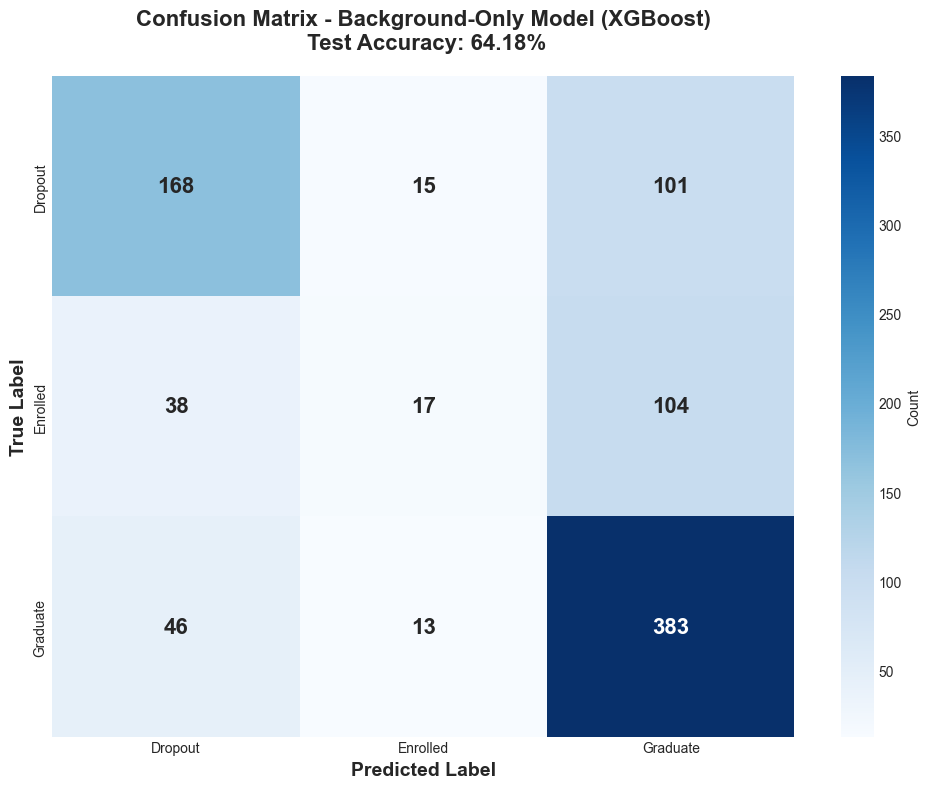


CONFUSION MATRIX BREAKDOWN

Actual Dropout (284 students):
  Correctly predicted Dropout:  168 (59.2%)
  Misclassified as Enrolled:    15 (5.3%)
  Misclassified as Graduate:    101 (35.6%)

Actual Enrolled (159 students):
  Correctly predicted Enrolled: 17 (10.7%)
  Misclassified as Dropout:     38 (23.9%)
  Misclassified as Graduate:    104 (65.4%)

Actual Graduate (442 students):
  Correctly predicted Graduate: 383 (86.7%)
  Misclassified as Dropout:     46 (10.4%)
  Misclassified as Enrolled:    13 (2.9%)


In [48]:
# Create and visualize confusion matrix for background-only model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm_bg = confusion_matrix(y_test_bg, y_test_pred_bg, labels=['Dropout', 'Enrolled', 'Graduate'])

# Create visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})

plt.title('Confusion Matrix - Background-Only Model (XGBoost)\n Test Accuracy: 64.18%', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../pics/confusion_matrix_background.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved to: ../pics/confusion_matrix_background.png")
plt.show()

# Print detailed breakdown
print("\n" + "="*70)
print("CONFUSION MATRIX BREAKDOWN")
print("="*70)
print("\nActual Dropout (284 students):")
print(f"  Correctly predicted Dropout:  {cm_bg[0,0]} ({cm_bg[0,0]/284*100:.1f}%)")
print(f"  Misclassified as Enrolled:    {cm_bg[0,1]} ({cm_bg[0,1]/284*100:.1f}%)")
print(f"  Misclassified as Graduate:    {cm_bg[0,2]} ({cm_bg[0,2]/284*100:.1f}%)")

print("\nActual Enrolled (159 students):")
print(f"  Correctly predicted Enrolled: {cm_bg[1,1]} ({cm_bg[1,1]/159*100:.1f}%)")
print(f"  Misclassified as Dropout:     {cm_bg[1,0]} ({cm_bg[1,0]/159*100:.1f}%)")
print(f"  Misclassified as Graduate:    {cm_bg[1,2]} ({cm_bg[1,2]/159*100:.1f}%)")

print("\nActual Graduate (442 students):")
print(f"  Correctly predicted Graduate: {cm_bg[2,2]} ({cm_bg[2,2]/442*100:.1f}%)")
print(f"  Misclassified as Dropout:     {cm_bg[2,0]} ({cm_bg[2,0]/442*100:.1f}%)")
print(f"  Misclassified as Enrolled:    {cm_bg[2,1]} ({cm_bg[2,1]/442*100:.1f}%)")
print("="*70)


## Section 9: Comparison with Full Model

Compare background-only model against the full model from baseline_models.ipynb

In [49]:
# Reference values from baseline_models.ipynb
dummy_baseline = 0.4993
full_model_accuracy = 0.7672  # XGBoost with all features

print("="*70)
print("COMPARATIVE ANALYSIS: Background vs Full Model")
print("="*70)

print("\nModel Performance:")
print("-" * 70)
print(f"  Dummy Baseline (Majority Class):      {dummy_baseline:.4f} ({dummy_baseline:.2%})")
print(f"  Background-Only ({best_model_name_bg}):          {test_accuracy_bg:.4f} ({test_accuracy_bg:.2%})")
print(f"  Full Model (XGBoost + All Features):  {full_model_accuracy:.4f} ({full_model_accuracy:.2%})")

print("\nPredictive Power Breakdown:")
print("-" * 70)
background_improvement = test_accuracy_bg - dummy_baseline
academic_improvement = full_model_accuracy - test_accuracy_bg
total_improvement = full_model_accuracy - dummy_baseline

print(f"  Background features contribute:    {background_improvement:.4f} ({background_improvement:.2%})")
print(f"  Academic features contribute:      {academic_improvement:.4f} ({academic_improvement:.2%})")
print(f"  Total improvement over baseline:   {total_improvement:.4f} ({total_improvement:.2%})")

background_pct = (background_improvement / total_improvement) * 100
academic_pct = (academic_improvement / total_improvement) * 100

print("\nContribution Percentages:")
print("-" * 70)
print(f"  Background factors: {background_pct:.1f}% of total predictive power")
print(f"  Academic performance: {academic_pct:.1f}% of total predictive power")

print("\n" + "="*70)
print("PRACTICAL IMPLICATIONS")
print("="*70)
print(f"\nBackground-Only Model ({test_accuracy_bg:.1%} accuracy):")
print("  ✓ Available at: Admission / Orientation Week")
print("  ✓ Enables: Proactive intervention before classes start")
print("  ✓ Use cases:")
print("    - Identify high-risk students for early support programs")
print("    - Allocate tutoring resources before struggles begin")
print("    - Financial aid counseling for at-risk students")
print("    - Peer mentoring program matching")

print(f"\nFull Model ({full_model_accuracy:.1%} accuracy):")
print("  ✓ Available at: After 2nd semester grades")
print("  ✓ Enables: Targeted intervention for struggling students")
print("  ✓ Use cases:")
print("    - Identify students at risk of dropping out")
print("    - Academic probation decisions")
print("    - Intensive support program enrollment")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)
print("\nUse BOTH models in a two-stage approach:")
print("  1. Stage 1 (Orientation): Background-only model flags high-risk students")
print("     → Provide proactive support from day one")
print("  2. Stage 2 (After 2nd semester): Full model identifies students who need help")
print("     → Targeted intervention for those showing academic struggles")
print("\nThis maximizes both early intervention and accuracy.")
print("="*70)

COMPARATIVE ANALYSIS: Background vs Full Model

Model Performance:
----------------------------------------------------------------------
  Dummy Baseline (Majority Class):      0.4993 (49.93%)
  Background-Only (XGBoost):          0.6418 (64.18%)
  Full Model (XGBoost + All Features):  0.7672 (76.72%)

Predictive Power Breakdown:
----------------------------------------------------------------------
  Background features contribute:    0.1425 (14.25%)
  Academic features contribute:      0.1254 (12.54%)
  Total improvement over baseline:   0.2679 (26.79%)

Contribution Percentages:
----------------------------------------------------------------------
  Background factors: 53.2% of total predictive power
  Academic performance: 46.8% of total predictive power

PRACTICAL IMPLICATIONS

Background-Only Model (64.2% accuracy):
  ✓ Available at: Admission / Orientation Week
  ✓ Enables: Proactive intervention before classes start
  ✓ Use cases:
    - Identify high-risk students for early s

## Section 10: Per-Class Analysis

In [50]:
print("="*70)
print("PER-CLASS PERFORMANCE: Background-Only Model")
print("="*70)

# Get per-class metrics
precision_bg, recall_bg, f1_bg, support_bg = precision_recall_fscore_support(
    y_test_bg, y_test_pred_bg,
    labels=['Dropout', 'Enrolled', 'Graduate'],
    average=None
)

classes = ['Dropout', 'Enrolled', 'Graduate']
print("\nDetailed Metrics:")
print("-" * 70)

for i, class_name in enumerate(classes):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision_bg[i]:.3f} - Of predicted {class_name}s, {precision_bg[i]:.1%} are correct")
    print(f"  Recall:    {recall_bg[i]:.3f} - Of actual {class_name}s, we catch {recall_bg[i]:.1%}")
    print(f"  F1-Score:  {f1_bg[i]:.3f}")
    print(f"  Support:   {support_bg[i]} students in test set")

print("\n" + "="*70)
print("INSIGHTS")
print("="*70)

if recall_bg[1] < 0.40:  # Enrolled class
    print("\n⚠ Enrolled Class Challenge:")
    print(f"  The model struggles with Enrolled students ({recall_bg[1]:.1%} recall)")
    print("  This is expected - without academic performance data, it's hard to")
    print("  distinguish who will eventually graduate vs drop out.")
    print("  → Full model with semester grades is needed for better Enrolled prediction")

if recall_bg[0] > 0.50:  # Dropout class
    print("\n✓ Dropout Detection:")
    print(f"  The model catches {recall_bg[0]:.1%} of dropouts using only background factors")
    print("  This demonstrates that pre-enrollment characteristics do predict risk")
    print("  → Early intervention can target these high-risk students from day one")

print("="*70)

PER-CLASS PERFORMANCE: Background-Only Model

Detailed Metrics:
----------------------------------------------------------------------

Dropout:
  Precision: 0.667 - Of predicted Dropouts, 66.7% are correct
  Recall:    0.592 - Of actual Dropouts, we catch 59.2%
  F1-Score:  0.627
  Support:   284 students in test set

Enrolled:
  Precision: 0.378 - Of predicted Enrolleds, 37.8% are correct
  Recall:    0.107 - Of actual Enrolleds, we catch 10.7%
  F1-Score:  0.167
  Support:   159 students in test set

Graduate:
  Precision: 0.651 - Of predicted Graduates, 65.1% are correct
  Recall:    0.867 - Of actual Graduates, we catch 86.7%
  F1-Score:  0.744
  Support:   442 students in test set

INSIGHTS

⚠ Enrolled Class Challenge:
  The model struggles with Enrolled students (10.7% recall)
  This is expected - without academic performance data, it's hard to
  distinguish who will eventually graduate vs drop out.
  → Full model with semester grades is needed for better Enrolled prediction

✓ 

## Section 11: Get Feature Importance (TOP 10)

In [51]:
# Get feature importance from background model
bg_feature_importance = best_model_bg.feature_importances_

# Create feature names list
bg_feature_names = (
    features_to_scale_bg +
    features_no_scale_bg +
    list(preprocessor_bg.named_transformers_['onehot'].get_feature_names_out(background_categorical)))

# Create dataframe and sort
importance_df_bg = pd.DataFrame({
    'feature': bg_feature_names,
    'importance': bg_feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Background Predictors:")
for _, row in importance_df_bg.head(10).iterrows():
    print(f"  {row['feature']:<40} {row['importance']:.4f}")


Top 10 Background Predictors:
  Tuition fees up to date                  0.1717
  Scholarship holder                       0.0693
  Gender                                   0.0396
  Course_9500                              0.0324
  Course_9119                              0.0322
  Debtor                                   0.0321
  Age at enrollment                        0.0287
  Course_9147                              0.0252
  mother_occupation_grouped_Student        0.0234
  Course_9853                              0.0227



✓ Feature importance plot saved to: ../pics/feature_importance_background.png


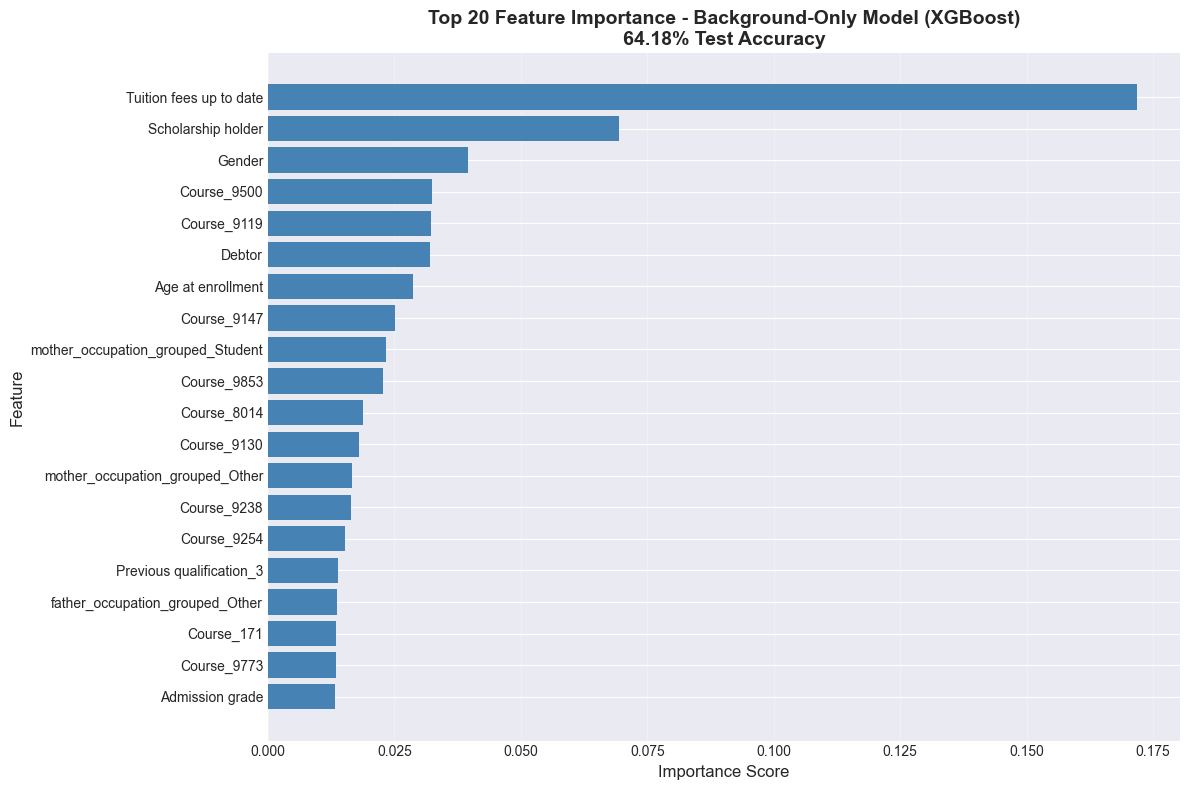

In [52]:
# Visualize feature importance for background-only model
plt.figure(figsize=(12, 8))
top_n = 20  # Show top 20 features

# Get top features
top_features_bg = importance_df_bg.head(top_n).sort_values('importance', ascending=True)

# Create horizontal bar plot
plt.barh(range(len(top_features_bg)), top_features_bg['importance'], color='steelblue')
plt.yticks(range(len(top_features_bg)), top_features_bg['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - Background-Only Model (XGBoost)\n64.18% Test Accuracy', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save to pics folder
plt.savefig('../pics/feature_importance_background.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Feature importance plot saved to: ../pics/feature_importance_background.png")

plt.show()
